In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
isdark = False

In [3]:
# initialization
from rayoptics.environment import *
from rayoptics.gui import dashboards

from matplotlib import gridspec
import matplotlib.colors as mcolors

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Create off-axis parabolic mirror model

In [4]:
app = AppManager(None)
opm = app.model = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']
print(f"{opm.ro_version=}")

opm.ro_version='0.9.5'


### Define first order aperture and field for system

In [5]:
pupil_diameter = 40.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'epd'], value=pupil_diameter)

# single field on-axis
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.0])

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([(555.0, 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [6]:
sm.gaps[0].thi = 1e+11

### setup aperture stop surface, then offset mirror behind the aperture stop

In [7]:
mirror_offset = srf.DecenterData('reverse', y=pupil_radius)
opm.add_dummy_plane(sd=pupil_radius, decenter=mirror_offset)
sm.set_stop();

### add parabolic mirror and enable it to tip, tilt and offset

In [8]:
offset_aperture = srf.Circular(radius=pupil_diameter, y_offset=0.)
#offset_aperture = srf.Circular(radius=pupil_radius, y_offset=pupil_radius)
mirror_perturb = srf.DecenterData('dec and return')
opm.add_mirror(power=1/80, cc=-1, t=-80, sd=pupil_diameter,
               decenter=mirror_perturb, clear_apertures=[offset_aperture])

### all of the system data has been entered, update the model

In [9]:
opm.update_model()

In [10]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
 Stop:     0.000000      0.00000       air             1      20.000
    2:    -0.006250     -80.0000       air    reflect -1      40.000
  Img:    -0.000000      0.00000                      -1  1.9267e-08


In [11]:
sm.list_decenters()

              thi    medium/mode          type          y       alpha
    0:  1.00000e+11          air
    1:                     dummy         reverse     20.000     0.0000
            0.00000          air
    2:                   reflect  dec and return     0.0000     0.0000
           -80.0000          air
    3:                     dummy


# List first order data

In [12]:
fod = opm['ar']['parax_data'].fod
fod.list_first_order_data()

efl                 -80
f                    80
f'                  -80
ffl                 -80
pp1                   0
bfl                 -80
ppk                  -0
pp sep                0
f/#                   2
m                -8e-10
red           -1.25e+09
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius           20
na obj            2e-10
n obj                 1
img_dist            -80
img_ht            1.396
exp_dist       -6.4e-08
exp_radius           20
na img             0.25
n img                -1
optical invariant       0.3491


# Draw a lens picture

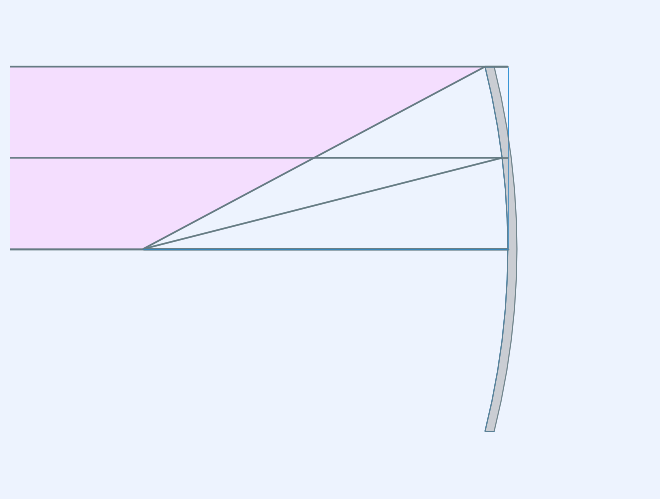

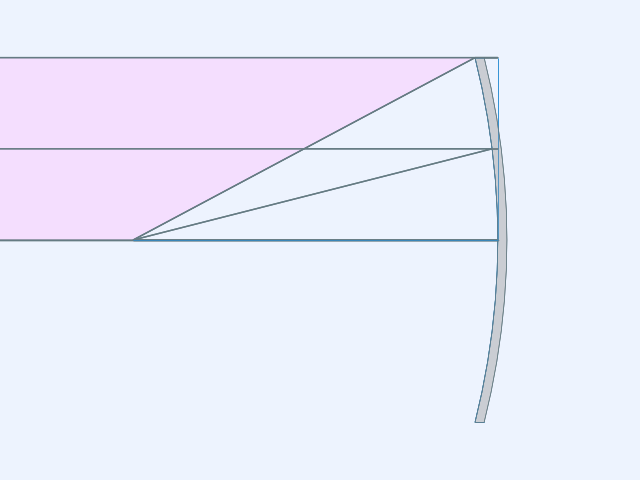

In [13]:
layout_plt0 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, refresh_gui=app.refresh_gui,
                        do_draw_rays=True, do_paraxial_layout=False, is_dark=isdark, offset_factor=0.15).plot()

app.add_figure(layout_plt0)

In [14]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

In [15]:
optical_axis_ray = trace_ray(opm, [0., 0.], fld, wvl)
list_ray(optical_axis_ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000        -1.25
  2:      0.00000     20.00000        -1.25     0.000000    -0.246154    -0.969231        81.25
  3:      0.00000      0.00000            0     0.000000    -0.246154    -0.969231            0


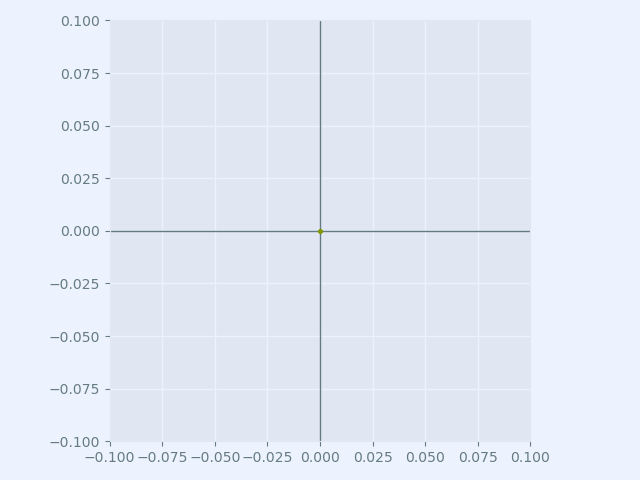

In [16]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
                      user_scale_value=0.1, is_dark=isdark).plot()

In [17]:
#sm.ifcs[2].decenter.euler[0] = 0.00573  # 0.1 mrad mirror tilt
sm.ifcs[2].decenter.euler[0] = 0.0573  # 1 mrad mirror tilt
opm.update_model()

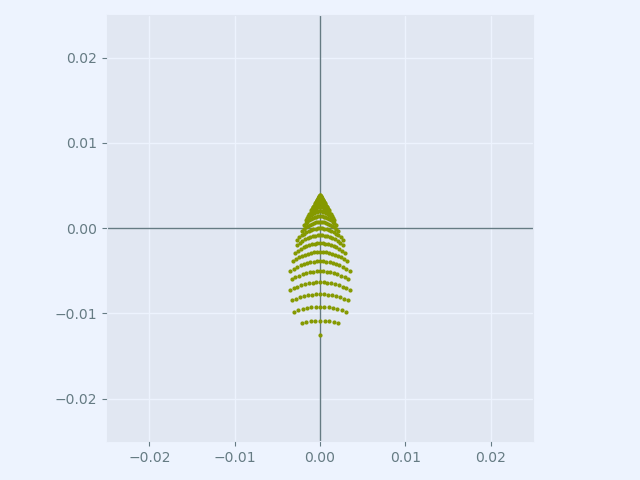

In [18]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
                      user_scale_value=0.025, is_dark=isdark).plot()

In [19]:
image_pt, ref_dir, ref_sphere_radius, lcl_tfrm_last = fld.ref_sphere

In [20]:
image_pt

array([ 0.        , -0.16389492,  0.        ])

In [21]:
fld.ref_sphere[0][1]=0

In [22]:
image_pt

array([0., 0., 0.])

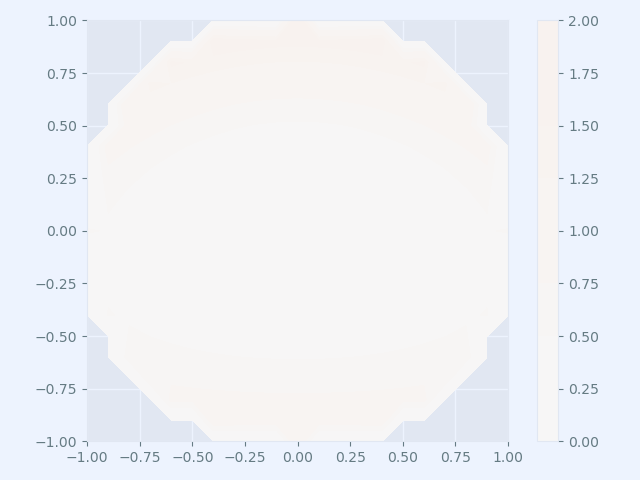

In [23]:
wavefront_plt = plt.figure(FigureClass=WavefrontFigure, opt_model=opm, scale_type=Fit.User_Scale,
                 user_scale_value=50., is_dark=isdark).plot()

In [24]:
upr_ray = trace_ray(opm, [0., 1.], fld, wvl)
list_ray(upr_ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000     20.00000            0     0.000000     0.000000     1.000000      -5.0413
  2:      0.00000     40.00502      -5.0013     0.000000    -0.471523    -0.881854       85.047
  3:      0.00000     -0.17648            0     0.000000    -0.472404    -0.881382            0


In [25]:
ctr_ray = trace_ray(opm, [0., 0.], fld, wvl)
list_ray(ctr_ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000      -1.2702
  2:      0.00000     20.00126      -1.2502     0.000000    -0.247138    -0.968980       81.271
  3:      0.00000     -0.16389            0     0.000000    -0.248107    -0.968733            0


In [26]:
lwr_ray = trace_ray(opm, [0., -1.], fld, wvl)
list_ray(lwr_ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000     -0.00000            0     0.000000    -0.000000     1.000000        1e+11
  1:      0.00000    -20.00000            0     0.000000    -0.000000     1.000000           -0
  2:      0.00000      0.00000            0     0.000000    -0.001000    -0.999999           80
  3:      0.00000     -0.16001            0     0.000000    -0.002000    -0.999998            0


In [27]:
list_ray(upr_ray, tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000       -1e+11     0.000000     0.000000     1.000000        1e+11
  1:      0.00000     20.00000            0     0.000000     0.000000     1.000000      -5.0413
  2:      0.00000     20.00000      -5.0413     0.000000    -0.472404    -0.881382       85.047
  3:      0.00000    -20.17648          -80     0.000000    -0.472404    -0.881382            0


In [28]:
list_ray(ctr_ray, tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000       -1e+11     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000      -1.2702
  2:      0.00000      0.00000      -1.2702     0.000000    -0.248107    -0.968733       81.271
  3:      0.00000    -20.16389          -80     0.000000    -0.248107    -0.968733            0


In [29]:
list_ray(lwr_ray, tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000       -1e+11     0.000000    -0.000000     1.000000        1e+11
  1:      0.00000    -20.00000            0     0.000000    -0.000000     1.000000           -0
  2:      0.00000    -20.00000            0     0.000000    -0.002000    -0.999998           80
  3:      0.00000    -20.16001          -80     0.000000    -0.002000    -0.999998            0


# Start of dynamic dashboard

In [30]:
sm.ifcs[2].decenter.euler[0] = 0.
opm.update_model()

In [31]:
img_offset = ctr_ray.pkg.ray[-1][mc.p]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

oa_ray = analyses.Ray(opm, [0., 0.], srf_save='all')
ray_grid = analyses.RayGrid(opm, f=fld, wl=wvl)
ray_list = analyses.RayList(opm, num_rays=48, f=fld, wl=wvl)

In [32]:
opd = opm.nm_to_sys_units(wvl)
# one wave of defocus
dfoc = opd/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)

# one wave of tilt
_, _, ref_sphere_radius, _ = fld.ref_sphere
shft = ref_sphere_radius*opd/fod.exp_radius

## Dashboard with wavefront map, spot diagram and geometrical PSF

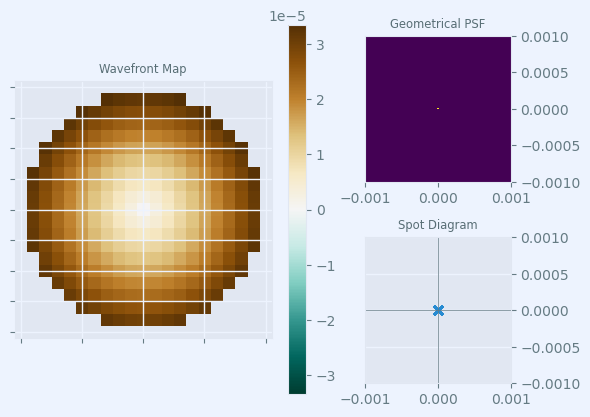

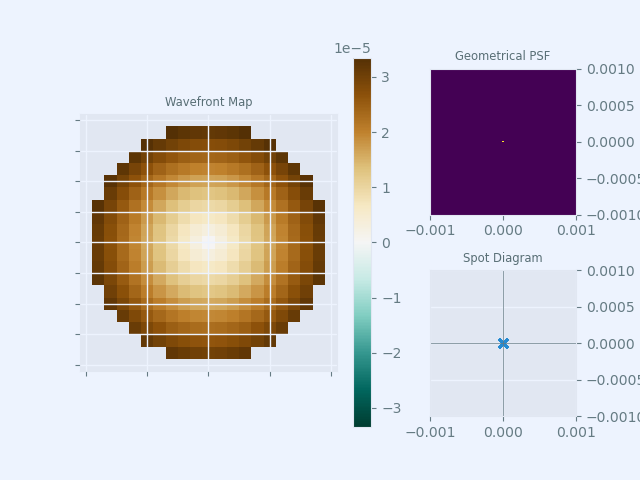

In [33]:
wfr = Wavefront(ray_grid, user_scale_value=None, do_contours=False, title='Wavefront Map',
                cmap="BrBG_r")
us = 0.001
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='right', title='Geometrical PSF')
sPOT = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')

fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_list], subplots=[wfr, gPSF, sPOT],
                 grid=(2, 3), is_dark=isdark)
fig.gridspecs = [fig.gs[0:2, 0:2], fig.gs[0, 2], fig.gs[1, 2]]

fig.plot()

In [34]:
len(ray_list.ray_list)

2304

## Dashboard of spot diagram and geometrical PSF

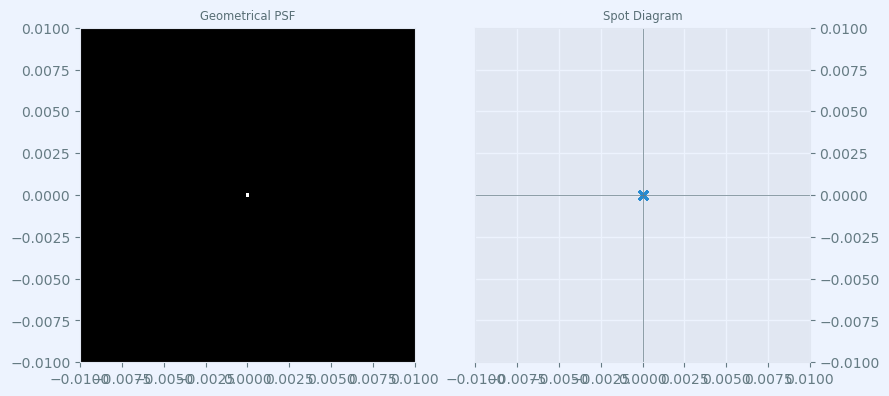

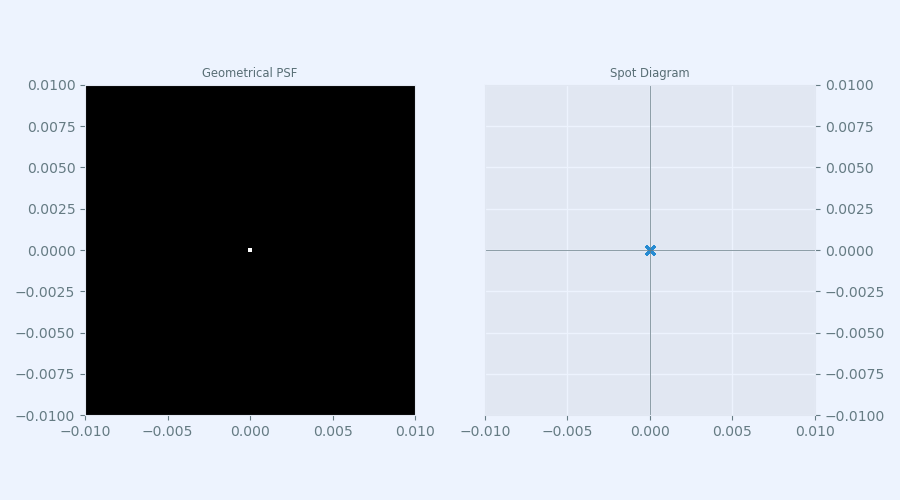

In [35]:
us = 0.01
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d', gamma=1./1.6,
                 yaxis_ticks_position='left', title='Geometrical PSF', cmap='gray')
spot = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')

spotfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list], subplots=[gPSF, spot],
                     grid=(1, 2), figsize=[9, 5], tight_layout=True, is_dark=isdark)

image_defocus = ray_list.foc
image_delta = ray_list.image_delta
#scaler = mcolors.Normalize(vmin=0., vmax=80)
spotfig.plot()

In [36]:
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([spotfig], [ray_list],
                                                              image_defocus, abs(dfoc),
                                                              0.2, image_delta)
display(widgets.HBox([defocus, y_shift]))

## Dashboard driven by mirror tilt

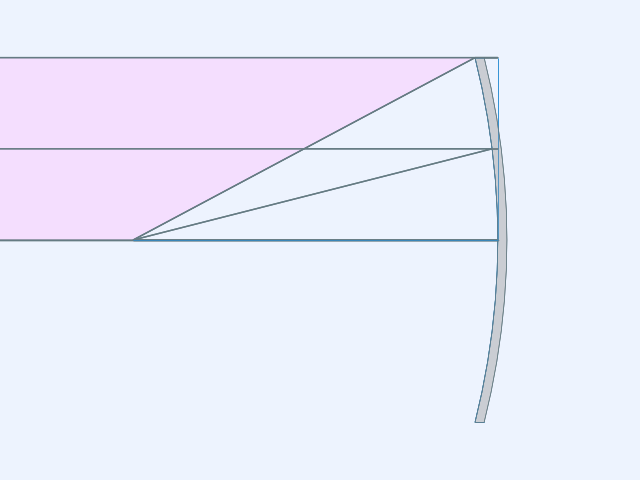

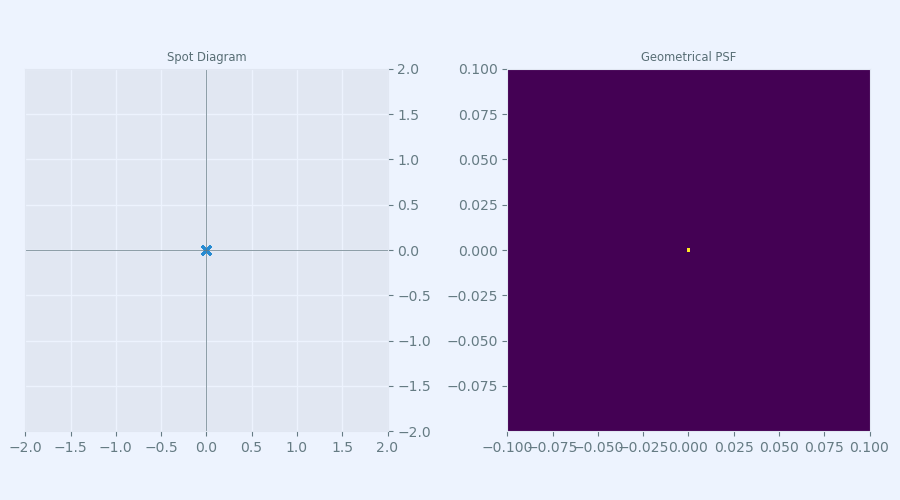

In [37]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, refresh_gui=app.refresh_gui,
                        do_draw_rays=True, do_paraxial_layout=False, offset_factor=0.15, is_dark=isdark).plot()
app.add_figure(layout_plt)

sPOT = RayGeoPSF(ray_list, user_scale_value=2.0, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')
gPSF = RayGeoPSF(ray_list, user_scale_value=0.1, scale_type='user centered', gamma=1./1.6,
                 dsp_typ='hist2d', title='Geometrical PSF')

fig_dash = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list], subplots=[sPOT, gPSF],
                      grid=(1, 2), figsize=[9, 5], tight_layout=True, is_dark=isdark)

fig_dash.refresh()

tilt_rng = 0.1146
tilt_rng = 100*shft/ref_sphere_radius
tilt_rng = math.degrees(math.atan(1/80.))
shift_rng = shft
shift_rng = 1

fig_list = [fig_dash]
alpha_tilt, x_dec, y_dec = dashboards.create_mirror_tilt_dashboard(sm.ifcs[2], app,
                                                                   fig_list, [ray_list],
                                                                   foc, tilt_rng, shift_rng,
                                                                   oa_ray=oa_ray,
                                                                   continuous_update=False)
display(widgets.HBox([alpha_tilt, x_dec, y_dec]))

In [38]:
sm.ifcs[2].decenter

'dec and return': Decenter: array([0., 0., 0.]), Tilt: array([0., 0., 0.])

In [39]:
oa_ray.update_data()
oa_ray.t_abr

array([0., 0.])

In [40]:
RaySeg(*oa_ray.ray_seg)

RaySeg(p=array([0.0000000e+00, 3.7782828e-15, 0.0000000e+00]), d=array([ 0.        , -0.24615385, -0.96923077]), dst=0.0, nrml=array([0., 0., 1.]))

In [41]:
list_ray(oa_ray.ray_pkg)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000        -1.25
  2:      0.00000     20.00000        -1.25     0.000000    -0.246154    -0.969231        81.25
  3:      0.00000      0.00000            0     0.000000    -0.246154    -0.969231            0


In [42]:
sm.list_model()
print('')
sm.list_decenters()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
 Stop:     0.000000      0.00000       air             1      20.000
    2:    -0.006250     -80.0000       air    reflect -1      40.000
  Img:    -0.000000      0.00000                      -1  1.9267e-08

              thi    medium/mode          type          y       alpha
    0:  1.00000e+11          air
    1:                     dummy         reverse     20.000     0.0000
            0.00000          air
    2:                   reflect  dec and return     0.0000     0.0000
           -80.0000          air
    3:                     dummy
